In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('nyc-taxi-experiment')

2025/09/26 05:33:45 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/871152991212864172', creation_time=1758864825345, experiment_id='871152991212864172', last_update_time=1758864825345, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('/workspaces/mlops_datatalksclub/data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)**(0.5)

9.775464552087287

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


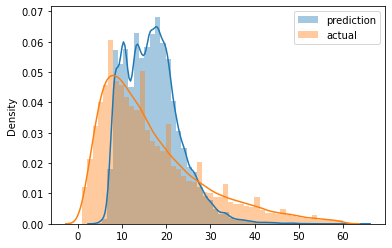

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('/workspaces/mlops_datatalksclub/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/workspaces/mlops_datatalksclub/data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)**(0.5)

7.479562160810692

In [17]:
with open('/workspaces/mlops_datatalksclub/models/model.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    mlflow.set_tag('test for hyperparameter','learning rate alpha')
    alpha=0.01
    lr = Lasso(alpha)
    mlflow.log_param('learning-rate',alpha)
    mlflow.log_param('model-name','Lasso Regression')
    mlflow.log_param('training-data','/workspaces/mlops_datatalksclub/data/green_tripdata_2021-01.parquet')
    mlflow.log_param('validation-data','/workspaces/mlops_datatalksclub/data/green_tripdata_2021-02.parquet')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse=mean_squared_error(y_val, y_pred)**(0.5)
    mlflow.log_metric('rmse',rmse)

🏃 View run gaudy-ape-580 at: http://127.0.0.1:5000/#/experiments/871152991212864172/runs/def87eadd02c42f88e2a7a5836f5a5b3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/871152991212864172


In [19]:
import xgboost as xgb
from hyperopt import fmin,tpe,hp,STATUS_OK,Trials
from hyperopt.pyll import scope

In [20]:
train=xgb.DMatrix(X_train,label=y_train)
valid=xgb.DMatrix(X_val,label=y_val)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model','xgboost')
        mlflow.log_params(params)
        booster=xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,'validation')],
            early_stopping_rounds=2
        )
        y_pred=booster.predict(valid)
        rsme=mean_squared_error(y_val, y_pred)**(0.5)
        mlflow.log_metric('rmse',rmse)
        return {'loss':rsme,'status':STATUS_OK}
        

In [23]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, S1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|                                       | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:34:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.70386                                                       
[1]	validation-rmse:9.58212                                                        
[2]	validation-rmse:8.75592                                                        
[3]	validation-rmse:8.16165                                                        
[4]	validation-rmse:7.73447                                                        
[5]	validation-rmse:7.42745                                                        
[6]	validation-rmse:7.21504                                                        
[7]	validation-rmse:7.06308                                                        
[8]	validation-rmse:6.95122                                                        
[9]	validation-rmse:6.87388                                                        
[10]	validation-rmse:6.81596                                                       
[11]	validation-rmse:6.77119                                                

[97]	validation-rmse:6.55851                                                       
[98]	validation-rmse:6.55857                                                       
[99]	validation-rmse:6.55751                                                       
[100]	validation-rmse:6.55673                                                      
[101]	validation-rmse:6.55618                                                      
[102]	validation-rmse:6.55547                                                      
[103]	validation-rmse:6.55497                                                      
[104]	validation-rmse:6.55435                                                      
[105]	validation-rmse:6.55326                                                      
[106]	validation-rmse:6.55257                                                      
[107]	validation-rmse:6.55195                                                      
[108]	validation-rmse:6.55120                                               

[194]	validation-rmse:6.51059                                                      
[195]	validation-rmse:6.51027                                                      
[196]	validation-rmse:6.50898                                                      
[197]	validation-rmse:6.50858                                                      
[198]	validation-rmse:6.50795                                                      
[199]	validation-rmse:6.50802                                                      
[200]	validation-rmse:6.50765                                                      
[201]	validation-rmse:6.50754                                                      
[202]	validation-rmse:6.50701                                                      
[203]	validation-rmse:6.50684                                                      
[204]	validation-rmse:6.50572                                                      
[205]	validation-rmse:6.50513                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:35:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54094                                                       
[1]	validation-rmse:10.93962                                                       
[2]	validation-rmse:10.40363                                                       
[3]	validation-rmse:9.92680                                                        
[4]	validation-rmse:9.50408                                                        
[5]	validation-rmse:9.13036                                                        
[6]	validation-rmse:8.79724                                                        
[7]	validation-rmse:8.50600                                                        
[8]	validation-rmse:8.25029                                                        
[9]	validation-rmse:8.02601                                                        
[10]	validation-rmse:7.82871                                                       
[11]	validation-rmse:7.65583                                                

[97]	validation-rmse:6.38817                                                       
[98]	validation-rmse:6.38773                                                       
[99]	validation-rmse:6.38730                                                       
[100]	validation-rmse:6.38690                                                      
[101]	validation-rmse:6.38622                                                      
[102]	validation-rmse:6.38570                                                      
[103]	validation-rmse:6.38507                                                      
[104]	validation-rmse:6.38455                                                      
[105]	validation-rmse:6.38388                                                      
[106]	validation-rmse:6.38332                                                      
[107]	validation-rmse:6.38304                                                      
[108]	validation-rmse:6.38252                                               

[194]	validation-rmse:6.35333                                                      
[195]	validation-rmse:6.35303                                                      
[196]	validation-rmse:6.35270                                                      
[197]	validation-rmse:6.35244                                                      
[198]	validation-rmse:6.35229                                                      
[199]	validation-rmse:6.35199                                                      
[200]	validation-rmse:6.35170                                                      
[201]	validation-rmse:6.35151                                                      
[202]	validation-rmse:6.35133                                                      
[203]	validation-rmse:6.35126                                                      
[204]	validation-rmse:6.35092                                                      
[205]	validation-rmse:6.35078                                               

[291]	validation-rmse:6.33550                                                      
[292]	validation-rmse:6.33540                                                      
[293]	validation-rmse:6.33527                                                      
[294]	validation-rmse:6.33501                                                      
[295]	validation-rmse:6.33503                                                      
[296]	validation-rmse:6.33488                                                      
[297]	validation-rmse:6.33467                                                      
[298]	validation-rmse:6.33452                                                      
[299]	validation-rmse:6.33423                                                      
[300]	validation-rmse:6.33422                                                      
[301]	validation-rmse:6.33425                                                      
[302]	validation-rmse:6.33408                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:38:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.84327                                                        
[1]	validation-rmse:6.75009                                                        
[2]	validation-rmse:6.72806                                                        
[3]	validation-rmse:6.72028                                                        
[4]	validation-rmse:6.71419                                                        
[5]	validation-rmse:6.70619                                                        
[6]	validation-rmse:6.70601                                                        
[7]	validation-rmse:6.70018                                                        
[8]	validation-rmse:6.69926                                                        
[9]	validation-rmse:6.69396                                                        
[10]	validation-rmse:6.68707                                                       
[11]	validation-rmse:6.68476                                                

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:38:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83375                                                        
[1]	validation-rmse:7.43761                                                        
[2]	validation-rmse:6.89541                                                        
[3]	validation-rmse:6.68413                                                        
[4]	validation-rmse:6.58934                                                        
[5]	validation-rmse:6.53611                                                        
[6]	validation-rmse:6.51225                                                        
[7]	validation-rmse:6.49506                                                        
[8]	validation-rmse:6.48095                                                        
[9]	validation-rmse:6.46719                                                        
[10]	validation-rmse:6.46173                                                       
[11]	validation-rmse:6.45737                                                

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:39:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80019                                                       
[1]	validation-rmse:11.41418                                                       
[2]	validation-rmse:11.05478                                                       
[3]	validation-rmse:10.72029                                                       
[4]	validation-rmse:10.40803                                                       
[5]	validation-rmse:10.11791                                                       
[6]	validation-rmse:9.84843                                                        
[7]	validation-rmse:9.59894                                                        
[8]	validation-rmse:9.36767                                                        
[9]	validation-rmse:9.15383                                                        
[10]	validation-rmse:8.95441                                                       
[11]	validation-rmse:8.77175                                                

[97]	validation-rmse:6.57276                                                       
[98]	validation-rmse:6.57202                                                       
[99]	validation-rmse:6.57159                                                       
[100]	validation-rmse:6.57074                                                      
[101]	validation-rmse:6.57007                                                      
[102]	validation-rmse:6.56951                                                      
[103]	validation-rmse:6.56876                                                      
[104]	validation-rmse:6.56840                                                      
[105]	validation-rmse:6.56745                                                      
[106]	validation-rmse:6.56661                                                      
[107]	validation-rmse:6.56633                                                      
[108]	validation-rmse:6.56592                                               

[194]	validation-rmse:6.53361                                                      
[195]	validation-rmse:6.53324                                                      
[196]	validation-rmse:6.53305                                                      
[197]	validation-rmse:6.53274                                                      
[198]	validation-rmse:6.53259                                                      
[199]	validation-rmse:6.53232                                                      
[200]	validation-rmse:6.53201                                                      
[201]	validation-rmse:6.53163                                                      
[202]	validation-rmse:6.53145                                                      
[203]	validation-rmse:6.53117                                                      
[204]	validation-rmse:6.53104                                                      
[205]	validation-rmse:6.53082                                               

[291]	validation-rmse:6.51056                                                      
[292]	validation-rmse:6.51031                                                      
[293]	validation-rmse:6.51009                                                      
[294]	validation-rmse:6.50997                                                      
[295]	validation-rmse:6.50977                                                      
[296]	validation-rmse:6.50965                                                      
[297]	validation-rmse:6.50934                                                      
[298]	validation-rmse:6.50913                                                      
[299]	validation-rmse:6.50875                                                      
[300]	validation-rmse:6.50853                                                      
[301]	validation-rmse:6.50842                                                      
[302]	validation-rmse:6.50809                                               

[388]	validation-rmse:6.49202                                                      
[389]	validation-rmse:6.49179                                                      
[390]	validation-rmse:6.49168                                                      
[391]	validation-rmse:6.49152                                                      
[392]	validation-rmse:6.49145                                                      
[393]	validation-rmse:6.49061                                                      
[394]	validation-rmse:6.49054                                                      
[395]	validation-rmse:6.49044                                                      
[396]	validation-rmse:6.49012                                                      
[397]	validation-rmse:6.48992                                                      
[398]	validation-rmse:6.48988                                                      
[399]	validation-rmse:6.48976                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:41:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.59060                                                       
[1]	validation-rmse:9.40923                                                        
[2]	validation-rmse:8.57262                                                        
[3]	validation-rmse:7.97930                                                        
[4]	validation-rmse:7.56367                                                        
[5]	validation-rmse:7.27590                                                        
[6]	validation-rmse:7.08031                                                        
[7]	validation-rmse:6.93807                                                        
[8]	validation-rmse:6.84268                                                        
[9]	validation-rmse:6.77621                                                        
[10]	validation-rmse:6.72213                                                       
[11]	validation-rmse:6.68441                                                

[97]	validation-rmse:6.48083                                                       
[98]	validation-rmse:6.48020                                                       
[99]	validation-rmse:6.47968                                                       
[100]	validation-rmse:6.47878                                                      
[101]	validation-rmse:6.47855                                                      
[102]	validation-rmse:6.47780                                                      
[103]	validation-rmse:6.47763                                                      
[104]	validation-rmse:6.47678                                                      
[105]	validation-rmse:6.47372                                                      
[106]	validation-rmse:6.47335                                                      
[107]	validation-rmse:6.47300                                                      
[108]	validation-rmse:6.47208                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:42:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.76208                                                       
[1]	validation-rmse:11.34338                                                       
[2]	validation-rmse:10.95560                                                       
[3]	validation-rmse:10.59666                                                       
[4]	validation-rmse:10.26512                                                       
[5]	validation-rmse:9.95833                                                        
[6]	validation-rmse:9.67531                                                        
[7]	validation-rmse:9.41483                                                        
[8]	validation-rmse:9.17489                                                        
[9]	validation-rmse:8.95475                                                        
[10]	validation-rmse:8.75203                                                       
[11]	validation-rmse:8.56615                                                

[97]	validation-rmse:6.53546                                                       
[98]	validation-rmse:6.53509                                                       
[99]	validation-rmse:6.53461                                                       
[100]	validation-rmse:6.53408                                                      
[101]	validation-rmse:6.53366                                                      
[102]	validation-rmse:6.53294                                                      
[103]	validation-rmse:6.53280                                                      
[104]	validation-rmse:6.53196                                                      
[105]	validation-rmse:6.53115                                                      
[106]	validation-rmse:6.53045                                                      
[107]	validation-rmse:6.52991                                                      
[108]	validation-rmse:6.52945                                               

[194]	validation-rmse:6.49513                                                      
[195]	validation-rmse:6.49488                                                      
[196]	validation-rmse:6.49462                                                      
[197]	validation-rmse:6.49431                                                      
[198]	validation-rmse:6.49395                                                      
[199]	validation-rmse:6.49366                                                      
[200]	validation-rmse:6.49343                                                      
[201]	validation-rmse:6.49317                                                      
[202]	validation-rmse:6.49287                                                      
[203]	validation-rmse:6.49256                                                      
[204]	validation-rmse:6.49203                                                      
[205]	validation-rmse:6.49180                                               

[291]	validation-rmse:6.46988                                                      
[292]	validation-rmse:6.46982                                                      
[293]	validation-rmse:6.46967                                                      
[294]	validation-rmse:6.46930                                                      
[295]	validation-rmse:6.46919                                                      
[296]	validation-rmse:6.46893                                                      
[297]	validation-rmse:6.46877                                                      
[298]	validation-rmse:6.46854                                                      
[299]	validation-rmse:6.46838                                                      
[300]	validation-rmse:6.46823                                                      
[301]	validation-rmse:6.46795                                                      
[302]	validation-rmse:6.46769                                               

[388]	validation-rmse:6.45170                                                      
[389]	validation-rmse:6.45154                                                      
[390]	validation-rmse:6.45129                                                      
[391]	validation-rmse:6.45094                                                      
[392]	validation-rmse:6.45074                                                      
[393]	validation-rmse:6.45058                                                      
[394]	validation-rmse:6.45044                                                      
[395]	validation-rmse:6.45027                                                      
[396]	validation-rmse:6.45008                                                      
[397]	validation-rmse:6.44996                                                      
[398]	validation-rmse:6.44981                                                      
[399]	validation-rmse:6.44965                                               

[485]	validation-rmse:6.43736                                                      
[486]	validation-rmse:6.43721                                                      
[487]	validation-rmse:6.43708                                                      
[488]	validation-rmse:6.43695                                                      
[489]	validation-rmse:6.43685                                                      
[490]	validation-rmse:6.43674                                                      
[491]	validation-rmse:6.43656                                                      
[492]	validation-rmse:6.43650                                                      
[493]	validation-rmse:6.43649                                                      
[494]	validation-rmse:6.43633                                                      
[495]	validation-rmse:6.43615                                                      
[496]	validation-rmse:6.43602                                               

[582]	validation-rmse:6.42553                                                      
[583]	validation-rmse:6.42545                                                      
[584]	validation-rmse:6.42529                                                      
[585]	validation-rmse:6.42519                                                      
[586]	validation-rmse:6.42511                                                      
[587]	validation-rmse:6.42501                                                      
[588]	validation-rmse:6.42493                                                      
[589]	validation-rmse:6.42487                                                      
[590]	validation-rmse:6.42474                                                      
[591]	validation-rmse:6.42466                                                      
[592]	validation-rmse:6.42443                                                      
[593]	validation-rmse:6.42427                                               

[679]	validation-rmse:6.41590                                                      
[680]	validation-rmse:6.41578                                                      
[681]	validation-rmse:6.41567                                                      
[682]	validation-rmse:6.41554                                                      
[683]	validation-rmse:6.41546                                                      
[684]	validation-rmse:6.41535                                                      
[685]	validation-rmse:6.41526                                                      
[686]	validation-rmse:6.41515                                                      
[687]	validation-rmse:6.41503                                                      
[688]	validation-rmse:6.41491                                                      
[689]	validation-rmse:6.41485                                                      
[690]	validation-rmse:6.41477                                               

[776]	validation-rmse:6.40766                                                      
[777]	validation-rmse:6.40759                                                      
[778]	validation-rmse:6.40754                                                      
[779]	validation-rmse:6.40744                                                      
[780]	validation-rmse:6.40727                                                      
[781]	validation-rmse:6.40725                                                      
[782]	validation-rmse:6.40720                                                      
[783]	validation-rmse:6.40717                                                      
[784]	validation-rmse:6.40706                                                      
[785]	validation-rmse:6.40698                                                      
[786]	validation-rmse:6.40692                                                      
[787]	validation-rmse:6.40681                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:44:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26293                                                       
[1]	validation-rmse:10.45990                                                       
[2]	validation-rmse:9.78450                                                        
[3]	validation-rmse:9.22008                                                        
[4]	validation-rmse:8.75066                                                        
[5]	validation-rmse:8.36188                                                        
[6]	validation-rmse:8.04202                                                        
[7]	validation-rmse:7.77986                                                        
[8]	validation-rmse:7.56528                                                        
[9]	validation-rmse:7.39206                                                        
[10]	validation-rmse:7.25002                                                       
[11]	validation-rmse:7.13316                                                

[97]	validation-rmse:6.49176                                                       
[98]	validation-rmse:6.49133                                                       
[99]	validation-rmse:6.49116                                                       
[100]	validation-rmse:6.49076                                                      
[101]	validation-rmse:6.49015                                                      
[102]	validation-rmse:6.48977                                                      
[103]	validation-rmse:6.48924                                                      
[104]	validation-rmse:6.48888                                                      
[105]	validation-rmse:6.48867                                                      
[106]	validation-rmse:6.48837                                                      
[107]	validation-rmse:6.48805                                                      
[108]	validation-rmse:6.48783                                               

[194]	validation-rmse:6.46989                                                      
[195]	validation-rmse:6.46945                                                      
[196]	validation-rmse:6.46942                                                      
[197]	validation-rmse:6.46933                                                      
[198]	validation-rmse:6.46910                                                      
[199]	validation-rmse:6.46909                                                      
[200]	validation-rmse:6.46911                                                      
[201]	validation-rmse:6.46900                                                      
[202]	validation-rmse:6.46888                                                      
[203]	validation-rmse:6.46871                                                      
[204]	validation-rmse:6.46857                                                      
[205]	validation-rmse:6.46845                                               

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:45:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.16170                                                       
[1]	validation-rmse:8.82277                                                        
[2]	validation-rmse:7.97506                                                        
[3]	validation-rmse:7.45201                                                        
[4]	validation-rmse:7.12822                                                        
[5]	validation-rmse:6.93376                                                        
[6]	validation-rmse:6.80395                                                        
[7]	validation-rmse:6.72525                                                        
[8]	validation-rmse:6.67138                                                        
[9]	validation-rmse:6.62610                                                        
[10]	validation-rmse:6.60356                                                       
[11]	validation-rmse:6.58649                                                

[97]	validation-rmse:6.44748                                                       
[98]	validation-rmse:6.44699                                                       
[99]	validation-rmse:6.44612                                                       
[100]	validation-rmse:6.44590                                                      
[101]	validation-rmse:6.44497                                                      
[102]	validation-rmse:6.44516                                                      
🏃 View run honorable-worm-315 at: http://127.0.0.1:5000/#/experiments/871152991212864172/runs/4e18c0f99b1c4ca0bc67031d37e3d946

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/871152991212864172      

 90%|████████████▌ | 9/10 [12:32<01:20, 80.67s/trial, best loss: 6.330763280335981]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:47:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.45478                                                        
[1]	validation-rmse:8.01837                                                        
[2]	validation-rmse:7.30280                                                        
[3]	validation-rmse:6.93953                                                        
[4]	validation-rmse:6.77393                                                        
[5]	validation-rmse:6.68389                                                        
[6]	validation-rmse:6.62407                                                        
[7]	validation-rmse:6.58887                                                        
[8]	validation-rmse:6.57168                                                        
[9]	validation-rmse:6.55539                                                        
[10]	validation-rmse:6.54530                                                       
[11]	validation-rmse:6.54189                                                